In [206]:
from math import sqrt
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima import model_selection
import matplotlib.dates as mdates
from datetime import timedelta
from tqdm import tqdm
pd.options.mode.chained_assignment = None 

### PROBLEM STATEMENT

The dataset includes more than 2 years of daily Sales data for more than 1.000 retail stores. Beside the sales figures the following information is provided on daily basis:
- number of Customers
- holidays
- shop open/closed
- promotion days

Target is to find the best possible model to forecast the sales for the next 4 weeks. Each model will be validated based on cumulated sales of all stores as well as individual forecasts for each specific store.

Due to the fact that we are working with time series data we will first start with statistical SARIMA(X) time series models. We will create an automated workflow to find the best model parameters, update train and test data and evaulate the model. Here we will not focus on any statistics for parameter selection like ACF, PACF as we want an automated solution.

After evaluation of different SARIMA models we will compare the results with some basic machine learning models like Linear Regression and tree-based regression models (Random Forest, XGBoost). 

Due to performance reasons we will focus on the evaluation on aggregated sales data mainly. As an outlook the process for individual store forecasts will be shown based on machine learning models.



**Exploratory Data Analysis**

In this first part we will have a detailed look at the shape of the input data and will also do some transformation steps which will be required for the models.

In [207]:
file_path="train_sales.csv"
df = pd.read_csv(file_path, sep="\,", quotechar='"')
df.head()

C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,"""Store","""""DayOfWeek""""","""""Date""""","""""Sales""""","""""Customers""""","""""Open""""","""""Promo""""","""""StateHoliday""""","""""SchoolHoliday"""""""
0,"""1",5,2015-07-31,5263,555,1,1,"""""0""""","""""1"""""""
1,"""2",5,2015-07-31,6064,625,1,1,"""""0""""","""""1"""""""
2,"""3",5,2015-07-31,8314,821,1,1,"""""0""""","""""1"""""""
3,"""4",5,2015-07-31,13995,1498,1,1,"""""0""""","""""1"""""""
4,"""5",5,2015-07-31,4822,559,1,1,"""""0""""","""""1"""""""


In [208]:
# first we clean the quote chars and rename the column headlines
df[df.columns[0]] = df[df.columns[0]].str.replace('"','')
df[df.columns[7]] = df[df.columns[7]].str.replace('"','')
df[df.columns[8]] = df[df.columns[8]].str.replace('"','')
df = df.rename(columns={
    df.columns[0]: 'Store',
    df.columns[1]: 'WeekDay',
    df.columns[2]: 'Date',
    df.columns[3]: 'Sales',
    df.columns[4]: 'Customers',
    df.columns[5]: 'Open',
    df.columns[6]: 'Promo',
    df.columns[7]: 'StateHoliday',
    df.columns[8]: 'SchoolHoliday'
})

In [209]:
# beside the date wwe directly create some additional time characteristics which might be helpful
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter

In [210]:
# let's get some basic information out of the dataset
Number_of_Stores = len(df['Store'].unique())
Average_Sales_per_Store = round(df['Sales'].mean())
Std_Sales_per_Store = round(df['Sales'].std())
                       
print(f"Total number of Stores: {Number_of_Stores}")
print(f"Average Sales per Store: {Average_Sales_per_Store}")
print(f"Standard Deviation of Sales per Store: {Std_Sales_per_Store}")

Total number of Stores: 1115
Average Sales per Store: 5774
Standard Deviation of Sales per Store: 3850


In [211]:
# for the aggregated forecast of all stores we can group the data accordingly. 
# Open and Promo seems to be relatively constant for almost all the shops so we can also just sum it up.
df_aggr = df.groupby(['Date', 'WeekDay', 'year', 'month', 'quarter']).sum()
df_aggr

,,,,,Sales,Customers,Open,Promo
Date,WeekDay,year,month,quarter,,,,
2013-01-01,2,2013,1,1,97235,19491,17,0
2013-01-02,3,2013,1,1,6949829,834075,1111,0
2013-01-03,4,2013,1,1,6347820,761040,1109,0
2013-01-04,5,2013,1,1,6638954,782137,1108,0
2013-01-05,6,2013,1,1,5951593,687472,1107,0
...,...,...,...,...,...,...,...,...
2015-07-27,1,2015,7,3,10707292,970462,1113,1115
2015-07-28,2,2015,7,3,9115073,876092,1113,1115
2015-07-29,3,2015,7,3,8499962,828524,1113,1115


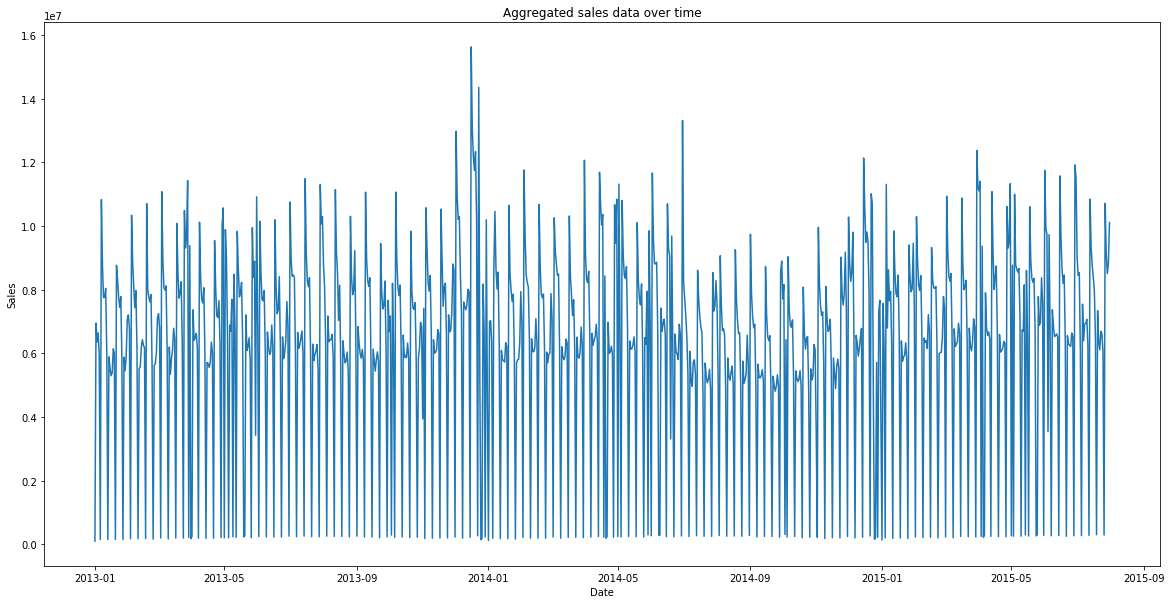

In [212]:
# Plot of the aggregated sales data
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
x = mdates.num2date(mdates.datestr2num(df_aggr.index.get_level_values(0)))
y = df_aggr['Sales']
ax.plot(x, y)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Aggregated sales data over time')
plt.show()

**Data Preparation**

We will now prepare the data, define our target variable and generate the model features. 

In [213]:
# convert multilevel dataset index to date, set frequency to daily
df_aggr.index = df_aggr.index.get_level_values(0)
df_aggr = df_aggr.asfreq('d')

# set target variable for our forecasting models
df_y = df_aggr[['Sales']]
df_y

,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593
...,...
2015-07-27,10707292
2015-07-28,9115073
2015-07-29,8499962


In [214]:
# create features for our forecasting models.
df_x = df.groupby(['Date', 'WeekDay', 'year', 'month', 'quarter']).sum()
# convert the genereated multilevel index into feature columns and reset index to date
df_x.drop(['Sales'], axis=1, inplace=True)
df_x['WeekDay'] = df_x.index.get_level_values(1)
df_x['year'] = df_x.index.get_level_values(2)
df_x['month'] = df_x.index.get_level_values(3)
df_x['quarter'] = df_x.index.get_level_values(4)
df_x.index = df_x.index.get_level_values(0)
df_x = df_x.asfreq('d')
df_x.head()

,Customers,Open,Promo,WeekDay,year,month,quarter
Date,,,,,,,
2013-01-01,19491,17,0,2,2013,1,1
2013-01-02,834075,1111,0,3,2013,1,1
2013-01-03,761040,1109,0,4,2013,1,1
2013-01-04,782137,1108,0,5,2013,1,1
2013-01-05,687472,1107,0,6,2013,1,1


In [215]:
# we can use this data in the models but in a real forecast scenario we will not know the Customer figures in advance
# instead we will use the rolling mean of the last 4 week days calculated individually for each day of the week

# sort according to week days
df_x_temp = df_x.sort_values(['WeekDay','year','month'])
df_x_temp

,Customers,Open,Promo,WeekDay,year,month,quarter
Date,,,,,,,
2013-01-07,1058495,1106,1115,1,2013,1,1
2013-01-14,734601,1105,0,1,2013,1,1
2013-01-21,884062,1107,1115,1,2013,1,1
2013-01-28,736906,1107,0,1,2013,1,1
2013-02-04,1018386,1109,1115,1,2013,2,1
...,...,...,...,...,...,...,...
2015-06-28,44422,32,0,7,2015,6,2
2015-07-05,47757,33,0,7,2015,7,3
2015-07-12,45392,32,0,7,2015,7,3


In [216]:
# for each week day we replace the actual Customers value with rolling mean of the last 3 week days
for i in df_x_temp['WeekDay'].unique():
    df_x_temp['Customers'][df_x_temp['WeekDay'] == i] = df_x_temp['Customers'][df_x_temp['WeekDay'] == i].rolling(3).mean()

# sort index back with date and 
df_x = df_x_temp.sort_index()
df_x = df_x.asfreq('d')
# after this transformation we can check that we should have 14 missing values - 2 NANs for 7 week days
df_x.isna().sum()

Customers    14
Open          0
Promo         0
WeekDay       0
year          0
month         0
quarter       0
dtype: int64

In [217]:
# finally we shift the Customers column by 28 days which represents our forecasting period
df_x['Customers'] = df_x['Customers'].shift(28)

In [218]:
# we drop the NAN values and also cut these data rows from our target variable
df_x.dropna(inplace=True)
df_y = df_y[df_x.index[0]:]
# check with the dataframe shape
print(df_y.shape)
print(df_x.shape)

(900, 1)
(900, 7)


**Model Evaluation Metrics**

For the model evaluation of this regression model we could use several metrics like MSE, MAE or RMSE. Our model evaluation will be based on RMSE as this penalizing large errors more than MAE but not that strong as MSE. 

Due to the fact that we have a time series model here we cannot use the cross validation like for standard machine learning models. Therefore we will us a rolling-window cross validation. 

This means the order of data will not be shuffled and we split the initial data into train and test data based on a defined date (e.g. 365 day training, next 64 days test). The cross-validation comes in by the fact that based on the prediction period we always update the training data with the already forecasted test data points and then test the next data points with the updated model. For this purpose we will define an automated train/test pipeline for each of the models.

In [219]:
#Evaluation and prediction functions for aggregated model

class Time_Series_Model():
   
    def __init__(self, df, tr_start, tr_end, te_start, te_end, prediction_steps=28, ex=None, arima=True):
        '''
        INPUT VARIABLES:
        df               = target variable
        ex               = external regression variables (features)
        tr_start         = start of training period
        tr_end           = end of training period
        te_start         = start of test period
        te_end           = end of test period    
        prediction_steps = time period in days to predict
        '''
        # instantiate the input variables
        self.df = df              
        self.ex = ex              
        self.tr_start = tr_start  
        self.tr_end = tr_end      
        self.te_start = te_start  
        self.te_end = te_end      
        self.prediction_steps = prediction_steps        
        #split data in train and test period
        self.X_train = df[tr_start:tr_end]
        self.X_test = df[te_start:te_end]
        # if external regression variables are available set train/test dataframes for esternal variables
        if self.ex is not None:          
            self.ex_train = ex[tr_start:tr_end]
            self.ex_test = ex[te_start:te_end]
 
        def auto_arima_parameters(seasonal=7):
            '''
            INPUT VARIABLES:
            seasonal = SARIMA parameters for seasonality (7 for weekly)

            This function provides the best parameters based on AIC value fitted on the input data.
            As value ranges we will use 0-5 for p,q and 0-3 for seasonal P,Q parameters. Integrated parameters
            will be 0-1. This is based on best practice and should cover all kind of time series shapes.

            OUTPUT:
            config = best SARIMA parameters based on input data
            '''
            if self.ex is not None:          
                exog = self.ex
            else:
                exog = None           
            arima = pm.auto_arima(self.df, exogenous=exog,
                       start_p=0, start_q=0, start_d=0, start_P=0, start_D=0, start_Q=0, m=seasonal,
                       max_p=5, max_q=5, max_d=1, max_P=3, max_D=1, max_Q=3, 
                       seasonal=True, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)
            config = [arima.order, arima.seasonal_order, arima.trend]             
            return config        
        if arima:
            # instantiate best config for SARIMA model validation
            self.best_config = auto_arima_parameters()


        
        
    def sarima_model_validate(self, config=None):
        '''
        INPUT VARIABLES:
        config = SARIMA parameters in format (p,d,q), (P,D,Q,m), t
        
        This function validates a given SARIMA(X) model with metric RMSE. Train and test data
        will be rolled and updated based on the time period of prediction.
        
        OUTPUT:
        RMSE = Root Mean Squared Error
        model_fit = fitted model
        predictions = forecasted data
        '''
        # set auto arima parameters if no specific config is provided
        if config is None:
            config = self.best_config      
        # set configuration and train, test data sets
        order, sorder, trend = config
        train = self.X_train
        test = self.X_test
        # if external variables are used set dataframes
        if self.ex is not None:
            train_ex = self.ex_train 
            test_ex = self.ex_test
        else:
            train_ex=None
            test_ex=None
            exog=None
        # generate dataframe for predictions
        predictions = pd.DataFrame([], columns = ['Sales'])  
        # iterate through test data set and make predictions, for each step the training data of the model will be updated
        while test.shape[0] > 0:
            model = SARIMAX(train, exog=train_ex, order=order, seasonal_order=sorder, trend=trend,
                            enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            # if external variables are used set dataframes
            if self.ex is not None:
                exog=test_ex[:self.prediction_steps]
            # if remaining test data is smaller than the prediction period set the predict_to variable accordingly
            if len(test) < self.prediction_steps:
                predict_to = len(train)+len(test)-1
            else:
                predict_to = len(train)+self.prediction_steps-1
            # generate predictions for iteration
            y_hat = model_fit.predict(len(train), predict_to, exog=exog)
            # append predicted values to predicitions dataframe
            predictions = predictions.append(pd.DataFrame(y_hat, columns = ['Sales']))            
            #update dataframes - add predicted test data rows to train, remove predicted data rows
            train = train[self.prediction_steps:].append(test[:self.prediction_steps])
            test = test[self.prediction_steps:]
            if self.ex is not None:
                train_ex = train_ex[self.prediction_steps:].append(test_ex[:self.prediction_steps])
                test_ex = test_ex[self.prediction_steps:]
        # if negative predictions were generated we can set them to 0
        predictions[predictions['Sales'] < 0] = 0
        #validate model
        rmse = sqrt(mean_squared_error(self.X_test, predictions))
        return rmse, model_fit, predictions

    
    def min_max_scaler(self):
        '''
        Scales model data within range 0 to 1. Train / test data is updated accordingly.
        '''
        self.sc_in = MinMaxScaler()
        self.sc_ex = MinMaxScaler()
        # fit training data
        self.sc_in.fit(self.X_train.values.reshape(-1,1))
        self.sc_ex.fit(np.array(self.ex_train))
        #transform training and test data
        self.X_train = pd.DataFrame(self.sc_in.transform(self.X_train.values.reshape(-1,1)), 
                                    index=self.X_train.index,
                                    columns=['Sales'])
        self.X_test = pd.DataFrame(self.sc_in.transform(self.X_test.values.reshape(-1,1)), 
                                   index=self.X_test.index,
                                   columns=['Sales'])
        self.ex_train = pd.DataFrame(self.sc_ex.transform(np.array(self.ex_train)),
                                     index=self.ex_train.index,
                                     columns=self.ex_train.columns)
        self.ex_test = pd.DataFrame(self.sc_ex.transform(np.array(self.ex_test)),
                                    index=self.ex_test.index,
                                    columns=self.ex_test.columns)

        
    def ml_model_validate(self, model=LinearRegression()):
        # change naming convention from statistical ARIMA models to machine learning models
        X_train, X_test, y_train, y_test = self.ex_train, self.ex_test, self.X_train, self.X_test
        # generate dataframe for predictions
        predictions = pd.DataFrame([], columns = ['Sales'])  
        # iterate through test data set and make predictions, for each step model training data will be updated
        X_test_iter = X_test.copy()
        y_test_iter = y_test.copy()
        while X_test_iter.shape[0] > 0:
            model_fit = model.fit(X_train, y_train)
            y_hat = model_fit.predict(X_test_iter[:self.prediction_steps])
            # append predicted values to predicitions dataframe
            predictions = predictions.append(pd.DataFrame(y_hat.reshape(-1,1), columns = ['Sales']))            
            #update dataframes - add predicted test data rows to train, remove predicted data rows
            X_train = X_train[self.prediction_steps:].append(X_test_iter[:self.prediction_steps])
            y_train = y_train[self.prediction_steps:].append(y_test_iter[:self.prediction_steps])
            X_test_iter = X_test_iter[self.prediction_steps:]
            y_test_iter = y_test_iter[self.prediction_steps:]
        # if negative predictions were generated we can set them to 0
        predictions[predictions['Sales'] < 0] = 0
            #validate model
        rmse = sqrt(mean_squared_error(y_test, predictions))
        return rmse, model_fit, predictions
    

**Model 1 - SARIMAX**

As we can clearly a strong repetitive seasonal pattern in the sales data we will firstly go for a statistical SARIMA model which should easily be able to handle the pattern in the data by just training on the historical data. As an enhancement we will also add external variables to the model in order to improve accuracy (SARIMAX).

For this purpose we will create an own class Time_Series_Model including functions to find the best model parameters and automatically train, test and validate the data

In [15]:
# create SARIMAtime series model without external variables, only based on historic values
TS1 = Time_Series_Model(df_y, tr_start=df_y.index[0], tr_end='2014-12-31',
                        te_start = '2015-01-01', te_end = '2015-07-31')

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=29485.462, BIC=29495.066, Time=0.069 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=29389.765, BIC=29408.975, Time=0.762 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=29352.636, BIC=29371.846, Time=0.417 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=30925.025, BIC=30929.827, Time=0.030 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 7) (constant=True); AIC=29486.787, BIC=29501.194, Time=0.115 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 1, 7) (constant=True); AIC=29343.669, BIC=29367.681, Time=1.798 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 0, 7) (constant=True); AIC=29430.306, BIC=29449.515, Time=0.806 seconds
Fit ARIMA: (0, 0, 1)x(2, 0, 1, 7) (constant=True); AIC=29139.607, BIC=29168.421, Time=3.121 seconds
Fit ARIMA: (0, 0, 1)x(2, 0, 0, 7) (constant=True); AIC=29381.637, BIC=29405.649, Time=2.781 seconds
Fit ARIMA: (0, 0, 1)x(3, 0, 1, 7) (constant=True); AIC=2

In [16]:
# best config 
TS1.best_config

[(0, 0, 1), (3, 0, 2, 7), None]

In [17]:
rmse, model, predictions = TS1.sarima_model_validate()

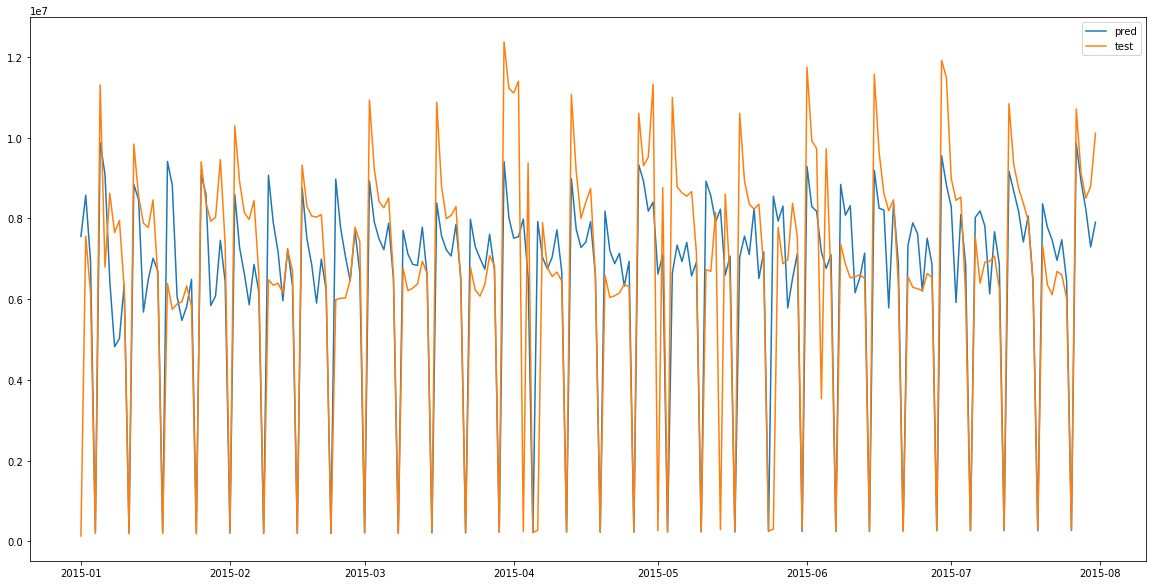

In [18]:
plt.figure(figsize=(20,10))
plt.plot(predictions.index, predictions.values, label='pred')
plt.plot(TS1.X_test.index, TS1.X_test.values, label='test')
plt.legend()
plt.show()

In [19]:
model_results = pd.DataFrame({'Model': ['SARIMA'], 'RMSE':[rmse]})
model_results

,Model,RMSE
0,SARIMA,1.879924e+06


In [113]:
# create SARIMA time series model, now with additional features
TS2 = Time_Series_Model(df_y, tr_start=df_y.index[0], tr_end='2014-12-31',
                        te_start = '2015-01-01', te_end = '2015-07-31', ex=df_x)

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=27431.366, BIC=27474.588, Time=0.182 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=27314.683, BIC=27367.510, Time=3.052 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=27351.000, BIC=27403.827, Time=3.424 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=32652.522, BIC=32690.941, Time=0.140 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=27341.449, BIC=27389.473, Time=1.403 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 7) (constant=True); AIC=27245.421, BIC=27303.049, Time=4.241 seconds
Fit ARIMA: (1, 0, 0)x(3, 0, 0, 7) (constant=True); AIC=27245.909, BIC=27308.340, Time=9.401 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 1, 7) (constant=True); AIC=27231.725, BIC=27294.156, Time=7.614 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=27194.975, BIC=27252.603, Time=7.763 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 7) (constant=True); AIC=2

In [114]:
# best config 
TS2.best_config

[(2, 0, 0), (2, 0, 2, 7), None]

In [115]:
rmse, model, predictions = TS2.sarima_model_validate()

In [116]:
rmse

813408.5173434014

In [117]:
# this model generated some negative predictions - we can set these values to 0 --> added to the function
# predictions[predictions['Sales'] < 0] = 0

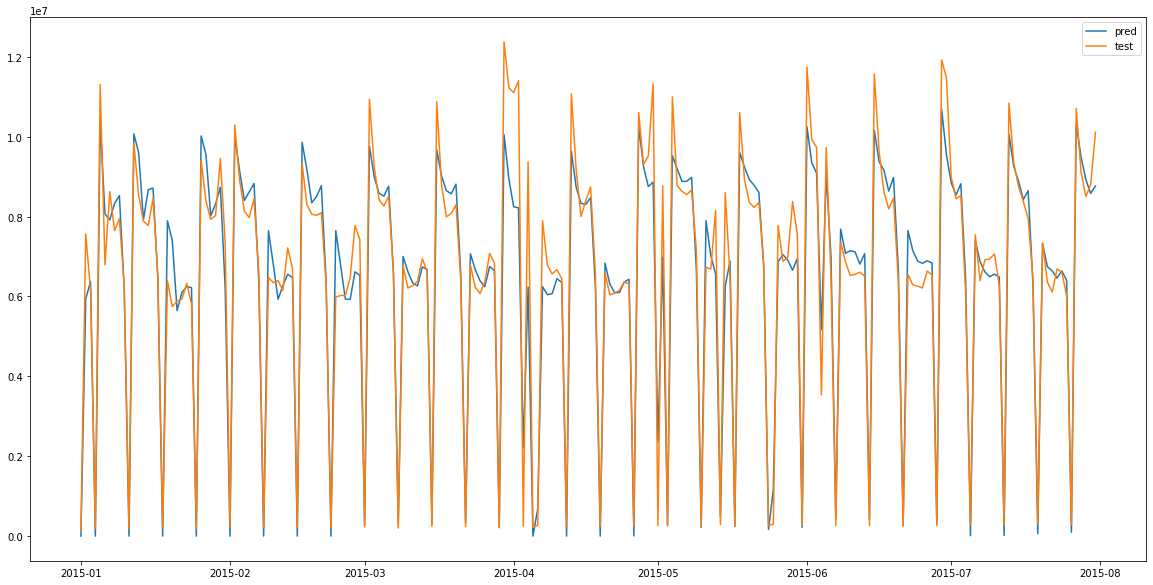

In [118]:
plt.figure(figsize=(20,10))
plt.plot(predictions.index, predictions.values, label='pred')
plt.plot(TS2.X_test.index, TS2.X_test.values, label='test')
plt.legend()
plt.show()

In [119]:
model_results = model_results.append(pd.DataFrame({'Model': ['SARIMAX'], 'RMSE':[rmse]}), ignore_index=True)

In [120]:
# we now perform the same model but we will scale all the parameters to 0,1
TS2.min_max_scaler()

In [121]:
rmse, model, predictions = TS2.sarima_model_validate()

C:\Users\q431587\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\q431587\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\q431587\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\q431587\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\q431587\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568

In [122]:
pred_transformed = TS2.sc_in.inverse_transform(predictions)
X_test_transformed = TS2.sc_in.inverse_transform(TS2.X_test)

In [123]:
rmse = sqrt(mean_squared_error(X_test_transformed, pred_transformed))
rmse

827537.4636609841

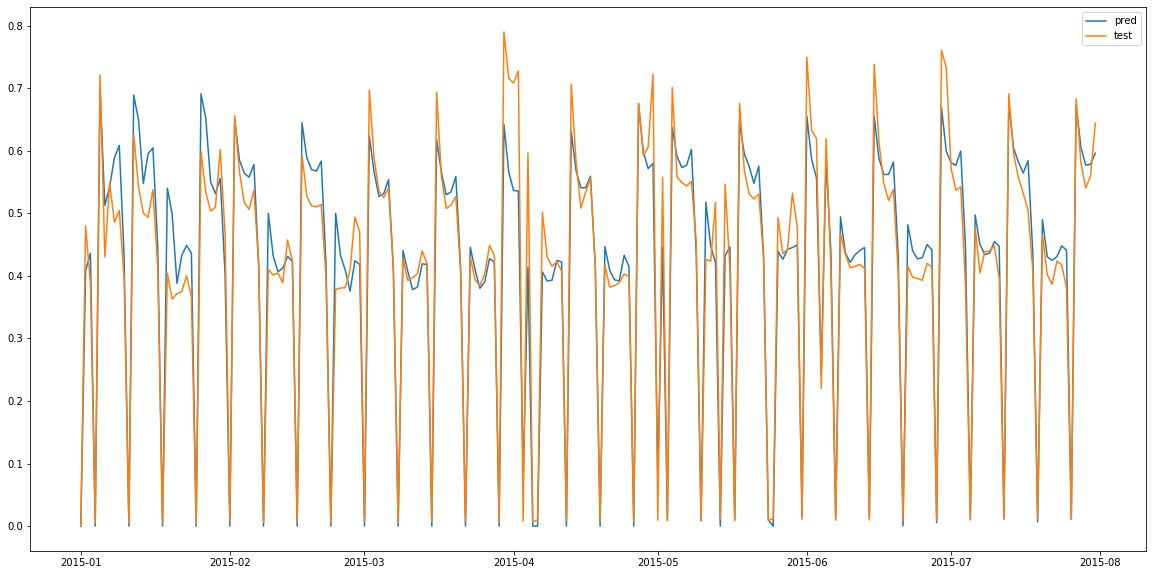

In [124]:
plt.figure(figsize=(20,10))
plt.plot(predictions.index, predictions.values, label='pred')
plt.plot(TS2.X_test.index, TS2.X_test.values, label='test')
plt.legend()
plt.show()

In [125]:
model_results = model_results.append(pd.DataFrame({'Model': ['SARIMAX scaled'], 'RMSE':[rmse]}), ignore_index=True)

In [126]:
model_results

,Model,RMSE
0,SARIMA,1.879924e+06
1,SARIMAX,8.134085e+05
2,SARIMAX scaled,8.275375e+05


**2. Machine Learning Models**

Next we will test some basic machine learning regression model. For the validation a help function was created. in this step first check the model outputs without any hyperparameter tuning. For the best models we will then further optimize in the next step. As we cannot use a classic cross validation for the time series data we will not use the GridSearch function from sklearn.

**Model 1 - Linear Regression**

In [134]:
TS3 = Time_Series_Model(df_y, tr_start=df_y.index[0], tr_end='2014-12-31',
                        te_start = '2015-01-01', te_end = '2015-07-31', ex=df_x, arima=False)
TS3.min_max_scaler()

In [135]:
rmse, model_fit, predictions = TS3.ml_model_validate()

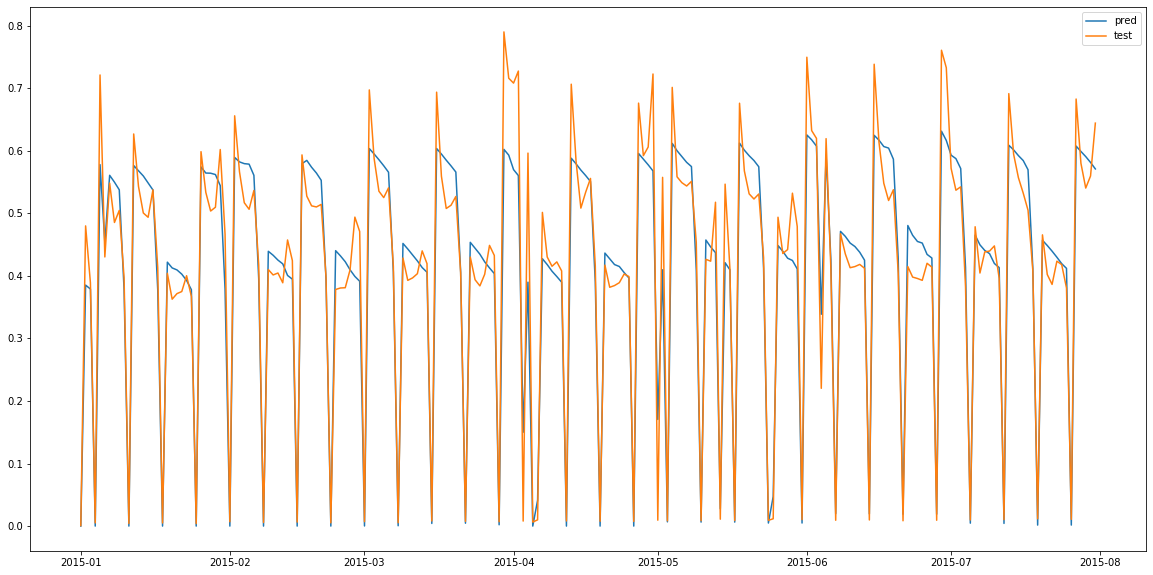

In [136]:
plt.figure(figsize=(20,10))
plt.plot(TS3.X_test.index, predictions, label='pred')
plt.plot(TS3.X_test.index, TS3.X_test.values, label='test')
plt.legend()
plt.show()

In [138]:
predictions_inversed = TS3.sc_in.inverse_transform(predictions)
X_test_inversed = TS3.sc_in.inverse_transform(TS3.X_test.values)
rmse = sqrt(mean_squared_error(X_test_inversed, predictions_inversed))
rmse

874792.9442781613

In [139]:
model_results = model_results.append(pd.DataFrame({'Model': ['Linear Regression'], 'RMSE':[rmse]}), ignore_index=True)
model_results.sort_values('RMSE')

,Model,RMSE
1,SARIMAX,8.134085e+05
2,SARIMAX scaled,8.275375e+05
3,Linear Regression,8.747929e+05
0,SARIMA,1.879924e+06


**Model 2 - XGBoost Regression**

In [140]:
# as we have seen all the SARIMA models had parameter d and D were 0 --> therefore no differentiation of time series necessary
TS4 = Time_Series_Model(df_y, tr_start=df_y.index[0], tr_end='2014-12-31',
                        te_start = '2015-01-01', te_end = '2015-07-31', ex=df_x, arima=False)

In [141]:
# generate XGBoost Model with some "best practice" parameters
model = xgb.XGBRegressor(colsample_bytree=1,
                 gamma=0,                 
                 learning_rate=0.001,
                 max_depth=2,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.8,
                 seed=42) 

rmse, model_fit, predictions = TS4.ml_model_validate(model=model)

In [142]:
rmse

661642.5714243249

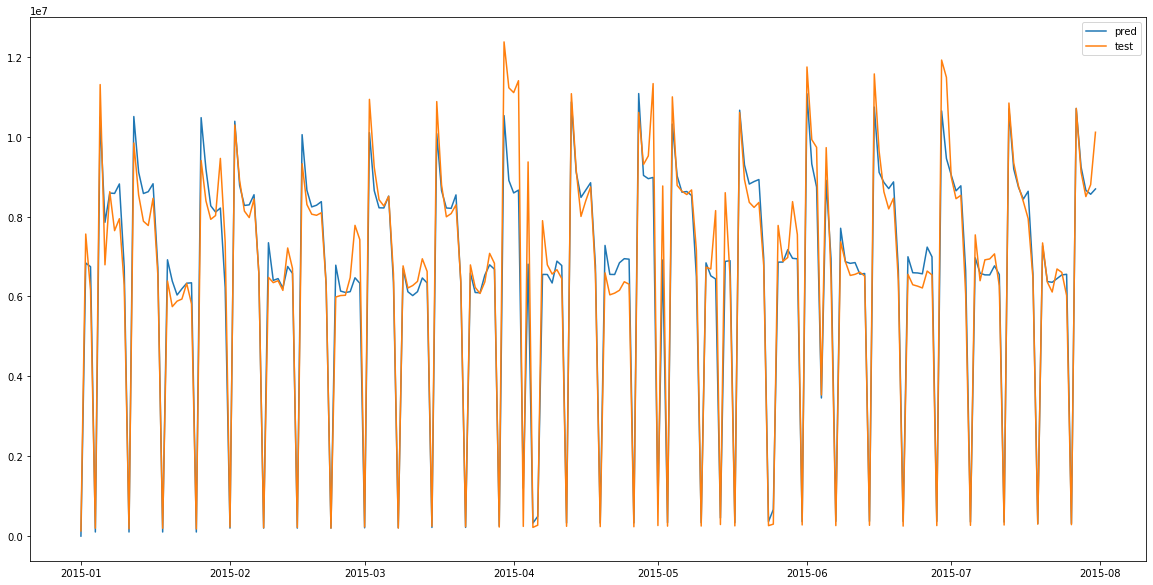

In [144]:
plt.figure(figsize=(20,10))
plt.plot(TS4.X_test.index, predictions, label='pred')
plt.plot(TS4.X_test.index, TS4.X_test.values, label='test')
plt.legend()
plt.show()

In [149]:
model_results = model_results.append(pd.DataFrame({'Model': ['XGBoost'], 'RMSE':[rmse]}), ignore_index=True)
model_results.sort_values('RMSE')

,Model,RMSE
4,XGBoost,6.616426e+05
1,SARIMAX,8.134085e+05
2,SARIMAX scaled,8.275375e+05
3,Linear Regression,8.747929e+05
0,SARIMA,1.879924e+06


**Model 3 - Random Forest Regression**

In [220]:
TS5 = Time_Series_Model(df_y, tr_start=df_y.index[0], tr_end='2014-12-31',
                        te_start = '2015-01-01', te_end = '2015-07-31', ex=df_x, arima=False)

In [221]:
rmse, model_fit, predictions = TS5.ml_model_validate(model=RandomForestRegressor())

C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel

In [222]:
rmse

657425.6768105007

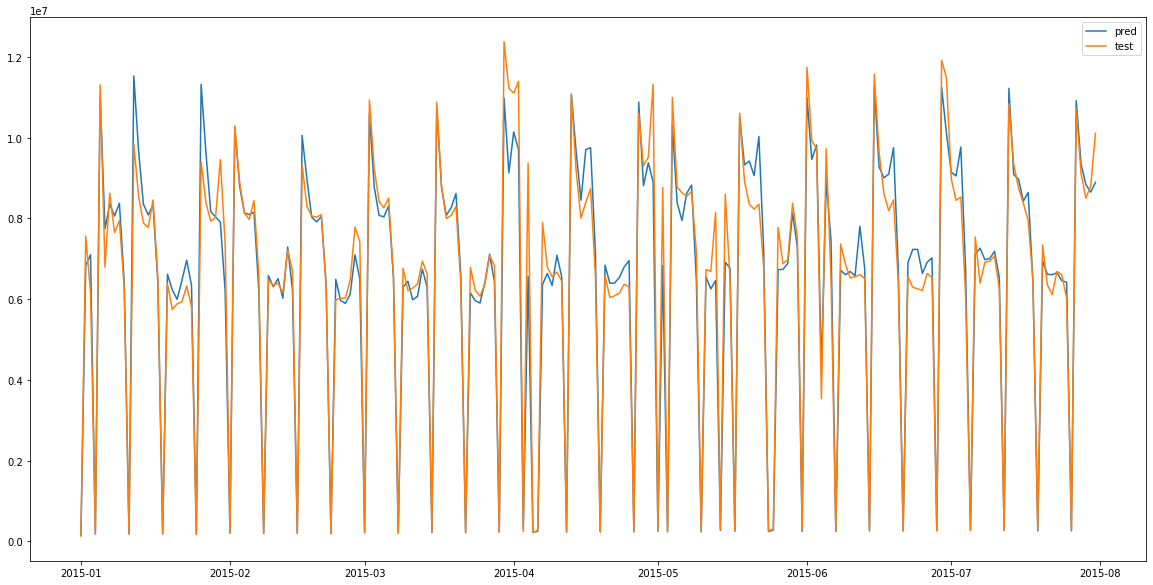

In [152]:
plt.figure(figsize=(20,10))
plt.plot(TS5.X_test.index, predictions, label='pred')
plt.plot(TS5.X_test.index, TS5.X_test.values, label='test')
plt.legend()
plt.show()

In [154]:
model_results = model_results.append(pd.DataFrame({'Model': ['Random Forest'], 'RMSE':[rmse]}), ignore_index=True)
model_results.sort_values('RMSE')

,Model,RMSE
5,Random Forest,6.547350e+05
4,XGBoost,6.616426e+05
1,SARIMAX,8.134085e+05
2,SARIMAX scaled,8.275375e+05
3,Linear Regression,8.747929e+05
0,SARIMA,1.879924e+06


**Model Results**

As we could see in the model evaluation a tuned statistical SARIMAX model performs better than a simple Linear Regression, but it is outclassed by a standard Random Forest and XGBoost. Furthermore the complexity in terms of data preparation, parameter tuning and usage of python methods is weigh higher than for any machine learning model. This might not be applicable for all datasets but for now we fill further focus on the machine learning models.

## **Hyperparameter Tuning for RandomForest Regression Model**
As mentioned due to to the rolling-window prediction and update of train data we cannot use the standard GridSearch which will perform a k-fold cross validation. Therefore we will manually iterate through some parameter combiantions and evaluate the RMSE score.

Most common used parameters which can be tweaked are number of estimators and the max tree depth of the model. This can also significantly affect performance.

In [227]:
# list contains parameters for n_estimators and max_depth
parameter_list = [
    [50, 2],
    [100, 2],
    [200, 2],
    [50, 5],
    [100, 5],
    [200, 5],
    [50, 10],
    [100, 10],
    [200, 10],                 
    [50, 20],
    [100, 20],
    [200, 20]                                   
                 ]

In [232]:
# generate with list of randomforest models to test
models=[]
for params in parameter_list:
    models.append(RandomForestRegressor(n_estimators=params[0], max_depth=params[1]))

In [238]:
TS6 = Time_Series_Model(df_y, tr_start=df_y.index[0], tr_end='2014-12-31',
                        te_start = '2015-01-01', te_end = '2015-07-31', ex=df_x, arima=False)

In [239]:
GridSearchResults = []
for model in tqdm(models):  
    rmse, model_fit, predictions = TS6.ml_model_validate(model=model)
    GridSearchResults.append([model.n_estimators, model.max_depth, rmse, predictions])

  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

 33%|███▎      | 4/12 [00:03<00:07,  1.11it/s]C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

 67%|██████▋   | 8/12 [00:09<00:05,  1.27s/it]C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:157: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

100%|██████████| 12/12 [00:18<00:00,  1.56s/it]


In [243]:
Evaluation_table = pd.DataFrame(GridSearchResults, columns=['n_estimators', 'max_depth', 'rmse', 'predictions'])

In [246]:
Evaluation_table.sort_values('rmse', inplace=True)
Evaluation_table

,n_estimators,max_depth,rmse,predictions
8,200,10,632097.310886,Sales 0 1.504018e+05 1 6.821352...
6,50,10,633511.802132,Sales 0 1.437279e+05 1 6.825940...
7,100,10,640483.558870,Sales 0 1.519685e+05 1 6.832960...
10,100,20,644827.299663,Sales 0 154420.13 1 6848031.6...
9,50,20,650684.465868,Sales 0 154924.06 1 6857123.6...
11,200,20,650871.132699,Sales 0 1.536918e+05 1 6.855285...
3,50,5,704363.335281,Sales 0 1.516551e+05 1 6.542494...
5,200,5,706518.870030,Sales 0 1.619102e+05 1 6.529915...
4,100,5,707735.200341,Sales 0 1.596875e+05 1 6.524437...
1,100,2,938173.795783,Sales 0 2.184723e+05 1 6.314409...


In [250]:
predictions = Evaluation_table['predictions'].iloc[0]

In [251]:
Evaluation_table['rmse'].iloc[0]

632097.3108856258

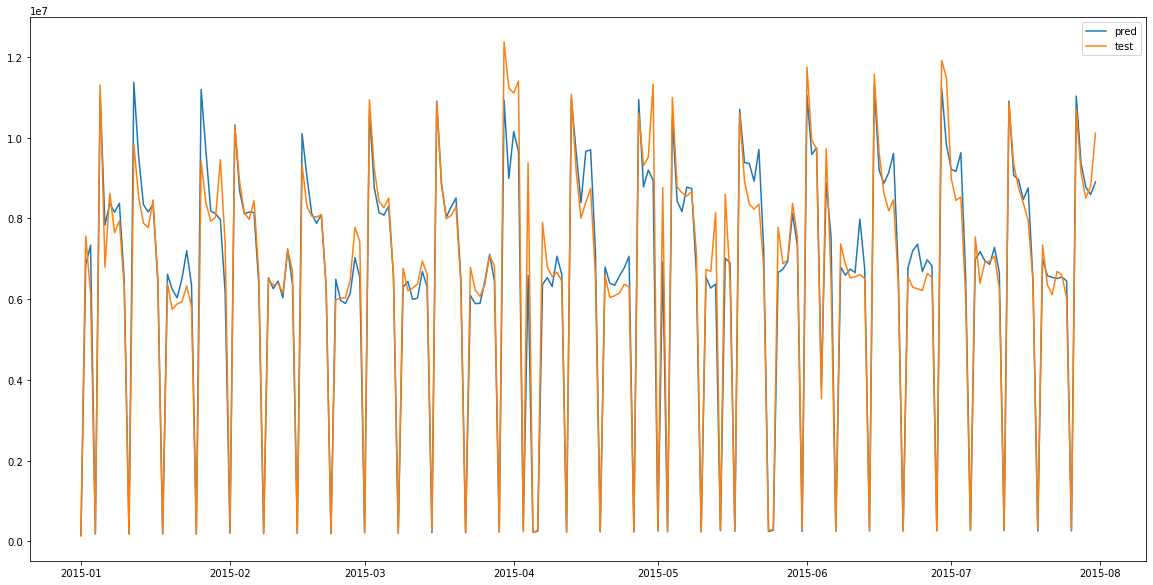

In [249]:
plt.figure(figsize=(20,10))
plt.plot(TS6.X_test.index, predictions, label='pred')
plt.plot(TS6.X_test.index, TS6.X_test.values, label='test')
plt.legend()
plt.show()

**Outlook  Data Preparation for Machine Learning Model for individual store forecast - NOT COMPLETE**

In [20]:
df_temp = df.sort_values(['Store','WeekDay','year','month','Date'])
df_temp

,Store,WeekDay,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,quarter
1009405,1,1,2013-01-07,7176,785,1,1,0,1,2013,1,1
1001600,1,1,2013-01-14,4717,616,1,0,0,0,2013,1,1
993795,1,1,2013-01-21,5394,607,1,1,0,0,2013,1,1
985990,1,1,2013-01-28,4055,549,1,0,0,0,2013,1,1
978185,1,1,2013-02-04,7032,762,1,1,0,0,2013,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
37793,999,7,2015-06-28,0,0,0,0,0,0,2015,6,2
29988,999,7,2015-07-05,0,0,0,0,0,0,2015,7,3
22183,999,7,2015-07-12,0,0,0,0,0,0,2015,7,3
14378,999,7,2015-07-19,0,0,0,0,0,0,2015,7,3


In [21]:
# this function might run up to 10 minutes (there might be a faster way somehow (np.vectorization ?!) but it worked)
# use tqdm module for display of progress bar
from tqdm import tqdm
# for each store and week day we replace the actual Customers value with rolling mean of the last 3 week days
for j in tqdm(df_temp['Store'].unique()):
    # generate a temporary dataframe for each store
    df_store = df_temp[df_temp['Store'] == j]
    for i in df_temp['WeekDay'].unique():
        # replace the customer actual value with the rolling mean
        df_store['Customers'][df_store['WeekDay'] == i] = df_store['Customers'][df_store['WeekDay'] == i].rolling(3).mean()
    # sort dataframe by date
    df_store = df_store.sort_values(['Date'])
    # shift the Customer column by the prediction period
    df_store['Customers'] = df_store['Customers'].shift(28)
    # create a new dataframe for the first iteration
    if j == df_temp['Store'].unique()[0]:
        df_new = df_store.copy()
    # append the store values for all other iterations
    else:        
        df_new = df_new.append(df_store)


100%|██████████| 1115/1115 [11:53<00:00,  1.56it/s]


In [22]:
# at the end we should exactly see 42 NAN datarows for each store --> rolling mean 7*2=14 + shift 28
df_new.isna().sum()/Number_of_Stores

Store             0.0
WeekDay           0.0
Date              0.0
Sales             0.0
Customers        42.0
Open              0.0
Promo             0.0
StateHoliday      0.0
SchoolHoliday     0.0
year              0.0
month             0.0
quarter           0.0
dtype: float64

In [25]:
# drop all the NAN values
df_new.dropna(inplace=True)
df_sorted = df_new.sort_values('Date')

In [32]:
df_sorted['Date'] =pd.to_datetime(df_sorted['Date'])

In [44]:
df_sorted['Date'].asfreq('d')
df_sorted['Date'].min()+timedelta(days=28)

Timestamp('2013-03-12 00:00:00')

In [46]:
df_sorted[df_sorted['Date'] >= df_sorted['Date'].min()+timedelta(days=28)]

,Store,WeekDay,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,quarter
938640,596,2,2013-03-12,3404,605.000000,1,0,0,0,2013,3,1
938443,399,2,2013-03-12,4112,403.000000,1,0,0,0,2013,3,1
939111,1067,2,2013-03-12,4316,346.000000,1,0,0,0,2013,3,1
938770,726,2,2013-03-12,8773,1070.000000,1,0,0,0,2013,3,1
938878,834,2,2013-03-12,4378,650.333333,1,0,0,0,2013,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
161,162,5,2015-07-31,10735,571.666667,1,1,0,1,2015,7,3
403,404,5,2015-07-31,6690,580.000000,1,1,0,1,2015,7,3
255,256,5,2015-07-31,11536,967.666667,1,1,0,1,2015,7,3
218,219,5,2015-07-31,3511,406.000000,1,1,0,1,2015,7,3


In [135]:
tr_start='2015-01-01'
tr_end='2015-03-31'
te_start = '2015-04-01'
te_end = '2015-04-30'

df_new.sort_values('Date', inplace=True)

# set target variable and features
df_y = df_new[['Sales']]
df_x = df_new.drop(['Sales'], axis=1)
# set train and test data


In [137]:
df_x['Date'] = pd.to_datetime(df_x['Date'] )

In [138]:
# some replacements were necessary for the StateHoliday column ...
df_new.StateHoliday = df_new.StateHoliday.replace('a','1')
df_new.StateHoliday = df_new.StateHoliday.replace('b','2')
df_new.StateHoliday = df_new.StateHoliday.replace('c','3')

In [202]:
# as the data structure is different we cannot use our initially created Time_Series_Model class here as we cannot use the date as index
# for this purpose we will just use the ml_model_validate function and adjust the input parameters


### FROM HERE ON NOT COMPLETE - WORK IN PROGRESS

def ml_model_validate_2(model, df, tr_start, tr_end, te_start, te_end, prediction_steps=28):
    '''
    INPUT VARIABLES:
    df               = target variable
    ex               = external regression variables (features)
    tr_start         = start of training period
    tr_end           = end of training period
    te_start         = start of test period
    te_end           = end of test period    
    prediction_steps = time period in days to predict
    '''
    df.sort_values('Date', inplace=True)
    df['Date'] =pd.to_datetime(df['Date'])
    # set target variable and features
    df_y = df_new[['Sales']]
    df_x = df_new.drop(['Sales'], axis=1)
    # set train and test data
    X_train = df_x[(df_x['Date'] <= tr_end) & (df_x['Date'] >= tr_start)]
    y_train = df_y[df_y.index.isin(X_train.index)]
    X_test = df_x[(df_x['Date'] >= te_start) & (df_x['Date'] <= te_end)]
    y_test = df_y[df_y.index.isin(X_test.index)]
    # generate dataframe for predictions
    predictions = pd.DataFrame([], columns = ['Sales'])  
    from_date_test = X_test['Date'].min()
    X_test_predict = X_test.copy()
    # iterate through test data set and make predictions, for each step model training data will be updated
    while X_test_predict.shape[0] > 0:
        # get min date from train and test dataframe
        from_date_train = X_train['Date'].min()
        # select dataframe for next predictions
        X_test_predict = X_test[X_test['Date'] <= from_date_test + timedelta(days=prediction_steps-1)]
        y_test_predict = y_test[y_test.index.isin(X_test_predict.index)]
        # y_train will now be reshaped to get rid of the warning messages
        model_fit = model.fit(X_train.drop('Date', axis=1), np.array(y_train).reshape(-1,))
        y_hat = model_fit.predict(X_test_predict.drop('Date', axis=1))
        # append predicted values to predicitions dataframe
        predictions = predictions.append(pd.DataFrame(y_hat.reshape(-1,1), columns = ['Sales']))            
        #update dataframes - add predicted test data rows to train, remove predicted data rows
        # remove first data rows from train and append predicted data rows from X_test
        X_train = X_train[X_train['Date'] > from_date_train + timedelta(days=prediction_steps-1)].append(X_test_predict)
        y_train = y_train[y_train.index.isin(X_train.index)].append(y_test_predict)
        # remove predicted data rows from X_test
        X_test_predict = X_test_predict[X_test['Date'] > from_date_test + timedelta(days=prediction_steps-1)]
        from_date_test = X_test_predict['Date'].min()
        #y_test_predict = y_test_predict[y_test.index.isin(X_test_predict.index)]
        print(X_test_predict.shape)
        print(y_test_predict.shape)
        # if negative predictions were generated we can set them to 0
    predictions[predictions['Sales'] < 0] = 0
    print(y_test.shape)
    print(predictions.shape)
    #validate model
    rmse = sqrt(mean_squared_error(y_test, predictions))
    return rmse, y_test, predictions

In [203]:
model = RandomForestRegressor(n_estimators=1, max_depth=2)

In [204]:
rmse, y_test, predictions= ml_model_validate_2(model, df_new, tr_start='2015-01-01', tr_end='2015-03-31',
                                                  te_start = '2015-04-01', te_end = '2015-05-30')

C:\Users\q431587\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(0, 11)
(31220, 1)
(66900, 1)
(31220, 1)


ValueError: Found input variables with inconsistent numbers of samples: [66900, 31220]

In [144]:
predictions

,Sales
0,6018.026172
1,6018.026172
2,0.000000
3,6018.026172
4,0.000000
...,...
13,0.000000
14,8140.989536
15,6031.000224
16,6031.000224


In [ ]:
parameter_grid = [[n_estimators=5, max_depth=2],
                  [n_estimators=10, max_depth=3],
                  [n_estimators=5, max_depth=5]]

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(TS5.X_test.index, predictions, label='pred')
plt.plot(TS5.X_test.index, TS5.X_test.values, label='test')
plt.legend()
plt.show()